# 🕹️👾 Reinforcement Learning aplicado a *Super Mario Bros* 👾🕹️

---

## Presentación de la práctica

Se entrega un **notebook modificado** para facilitar la comprensión y ejecución de la práctica desarrollada.  
Este cuaderno ha sido adaptado eliminando las celdas de los tutoriales de ejemplo y añadiendo nuevas secciones para mejorar el flujo de trabajo y el entendimiento del código.

🚀 **[Explora el proyecto en GitHub](https://github.com/AsahelHT/DeepRL_SuperMario)**  

---

## Resultado obtenido

<figure style="text-align: center; margin-top: 20px;">
  <img src="./media/gifs/PPO_CNN_3005_3.gif" alt="Mejor entrenamiento logrado" width="350">
  <figcaption style="font-style: italic; color: #555; margin-top: 10px;">
    🏆 Mejor entrenamiento logrado: <strong>PPO_CNN_3005_3</strong>
  </figcaption>
</figure>

---

## Estructura del Notebook

El notebook se organiza en **cuatro secciones principales**:

1. ⚙️ **Configuración del entorno**  
2. 🛠️ **Modificación y ampliación**  
3. 🧠 **Entrenamiento del agente**  
4. 📈 **Evaluación de desempeño**

Cada sección incluye comentarios y celdas auxiliares para facilitar la experimentación y comprensión del aprendizaje por refuerzo profundo.

---
---

## 1. ⚙️ Configuración inicial del entorno

Para ejecutar correctamente este notebook, se recomienda usar un entorno `conda` o equivalente con:

- **Python 3.8**
- Todas las dependencias detalladas en el archivo `requirements.txt` incluido con el proyecto

Puedes crear el entorno ejecutando:

```bash
conda create -n mario_rl python=3.8
pip install -r requirements.txt

```

Lo primero es importar las librerías necesarias para ejecutar el entorno:

In [1]:
import gymnasium as gym
# Gymnasium ofrece diferentes tipos de espacios para definir el espacio de acción y el espacio de observación.
# En este caso, usamos Box para definir un espacio de observación continuo, y Discrete para un espacio de acción discreto.
from gymnasium.spaces import Box, Discrete

# Para modificar el entorno de Gymnasium, usamos la clase Wrapper.
# Wrapper es una clase base que permite modificar el comportamiento de un entorno sin cambiar su implementación.
from gymnasium import Wrapper

# Del emulador de NES, importamos el espacio de acción que emula el joystick.
from nes_py.wrappers import JoypadSpace

# Importamos el entorno de Super Mario Bros.
import gym_super_mario_bros
# Como indica la documentacion, el entorno de Super Mario Bros. tiene diferentes espacios de acción.
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT, RIGHT_ONLY

from gym.wrappers import GrayScaleObservation
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack, SubprocVecEnv
from stable_baselines3.common.callbacks import EvalCallback

from stable_baselines3.common.callbacks import BaseCallback

from stable_baselines3.common.results_plotter import load_results, ts2xy
from typing import Callable
import matplotlib.pyplot as plt
import os

import cv2
import numpy as np

from collections import deque
import torch
from typing import Callable

# Variables de configuración
# Puedes cambiar el mundo y el nivel para probar diferentes niveles de Super Mario Bros.
# También puedes cambiar el tipo de acción y el número de frames apilados.
WORLD = 1
STAGE = 1
ACTION_TYPE = RIGHT_ONLY 
N_FRAMES_STACK = 4

---
---
## 2. 🛠️ Modificación y ampliación del entorno

Se han realizado diversas mejoras sobre el entorno original de entrenamiento con el objetivo de optimizar el rendimiento del agente y adaptar el entorno a las necesidades específicas del experimento.

<blockquote style="border-left: 4px solid #00bcd4; background: #f0faff; padding: 10px; color: #333;">
🔧 <strong>Modificaciones aplicadas:</strong>
<ul style="margin-top: 10px;">
  <li><strong>2.1 Preprocesado de la imagen:</strong> Reducción de tamaño, escala de grises y normalización de los fotogramas para facilitar el aprendizaje.</li>
  <li><strong>2.2 Personalización de la función de recompensa:</strong> Ajustes para incentivar el avance en el escenario y penalizar acciones no productivas.</li>
  <li><strong>2.3 Obtención de información temporal:</strong> Almacenamiento de estados anteriores para dotar al agente de una noción de secuencia (frame stacking).</li>
  <li><strong>2.4 Creación del entorno de entrenamiento:</strong> Se implementa la función que permite crear un entorno aplicando todos los Wrappers anteriores.</li>
</ul>
</blockquote>



### 2.1 Preprocesado de la imagen

El primer paso consiste en aplicar un **preprocesado a la imagen** recibida del entorno para reducir su complejidad y hacer más eficiente el aprendizaje del agente.

<blockquote style="border-left: 4px solid #4CAF50; background: #f9fff9; padding: 10px; color: #333;">
🖼️ <strong>Operaciones realizadas:</strong>
<ul style="margin-top: 10px;">
  <li><strong>Conversión a escala de grises:</strong> elimina el canal de color, conservando únicamente la información relevante.</li>
  <li><strong>Reducción de tamaño:</strong> disminuye la resolución para acortar los tiempos de cómputo y reducir la dimensionalidad.</li>
  <li><strong>Normalización:</strong> transforma los valores de píxel al rango <code>[0, 1]</code> para estabilizar el proceso de entrenamiento.</li>
</ul>
</blockquote>

La función implementada toma como entrada la **observación en crudo** proporcionada por el entorno (una imagen RGB) y devuelve una versión preprocesada siguiendo los pasos anteriores:


In [2]:

# Dimensiones de la imagen procesada
HEIGHT = 84
WIDTH = 84

# Aplica un procesamiento a la imagen del entorno para que sea más fácil de manejar.
def process_frame(frame):
    if frame is not None:
        if len(frame.shape) == 3 and frame.shape[2] == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        resized = cv2.resize(frame, (WIDTH, HEIGHT))
        normalized = resized / 255.0

        return normalized.astype(np.float32)  # Ensure the output is float32
    else:
        return np.zeros((HEIGHT, WIDTH), dtype=np.float32)

Con esto, pasamos de tener una observación de dimensiones 3x256x240, a 1xHEIGHTXWIDHT, reduciendo drásticamente nuestra representación del estado del mundo de Mario. 

### 2.2 Personalización de la función de recompensa

La función de recompensa ha sido diseñada para **alinear el comportamiento del agente con los objetivos del juego**, incentivando el progreso hacia la derecha, la rapidez y la supervivencia.

<blockquote style="border-left: 4px solid #ff9800; background: #fffaf0; padding: 10px; color: #333;">
🎯 <strong>Componentes de la recompensa:</strong>
<ul style="margin-top: 10px;">
  <li><strong>Progreso horizontal:</strong> se recompensa moverse a la derecha.</li>
  <li><strong>Puntuación:</strong> se recompensa la obtención de puntos.</li>
  <li><strong>Muerte del agente:</strong> penalización significativa por perder una vida.</li>
  <li><strong>Bandera final:</strong> recompensa alta por completar el nivel.</li>
</ul>
</blockquote>

Esta combinación de recompensas y penalizaciones permite guiar el entrenamiento del agente hacia una estrategia **eficiente y segura**.


In [ ]:
class CustomReward(Wrapper):
    def __init__(self, env=None):
        super(CustomReward, self).__init__(env)
        self.observation_space = Box(low=0, high=255, shape=(HEIGHT, WIDTH))
        self.action_space = Discrete(env.action_space.n)
        self.info = {}
        self.prev_x = 40
        self.prev_score = 0 
        #self.prev_time = None
        self.prev_lives = 2

    def step(self, action):
        obs, reward, done, trunk, info = self.env.step(action)
        self.info = info
        processed_img = process_frame(obs)

        reward = 0.0

        delta_x_reward = 0.0
        delta_score_reward = 0.0
        flag_reward = 0.0
        death_penalty = 0.0

        # Penalizacion si muere o no llega a la meta
        current_lives = info.get('life', self.prev_lives)
        if current_lives < self.prev_lives:
            death_penalty -= 50.0  

        # Recompensa por avanzar, penalizacion por quedarse quieto
        delta_x = info['x_pos'] - self.prev_x
        if delta_x > 0:
            delta_x_reward += delta_x * 0.1
            
        # Recompensa si llega a la meta
        if info.get('flag_get', False):
            flag_reward += 100.0

        # Recompensa por incremento en la puntuacion
        delta_score = info['score'] - self.prev_score
        if delta_score > 0:
            delta_score_reward += delta_score * 0.01  

        self.prev_lives = current_lives

        # Actualización de valores previos
        self.prev_x = info['x_pos']
        self.prev_score = info['score']  

        # Función de recompensa 
        reward = death_penalty + delta_x_reward + flag_reward + delta_score_reward

        return processed_img, reward, done, trunk, info

    def reset(self, **kwargs):

        self.prev_score = 0
        self.prev_x = 40
        self.prev_lives = 2

        obs, info = self.env.reset()
        obs = process_frame(obs)
        return obs, info



### 2.3 Obtención de información temporal

Para que el agente sea capaz de interpretar el movimiento en el entorno (como la velocidad o dirección de los objetos), es necesario proporcionarle **información temporal**. Esto se consigue mediante el uso de **wrappers personalizados**.

<blockquote style="border-left: 4px solid #3f51b5; background: #f4f6ff; padding: 10px; color: #333;">
⏳ <strong>Mecanismos implementados:</strong>
<ul style="margin-top: 10px;">
  <li><strong>Apilamiento de N frames consecutivos:</strong> se almacena una secuencia de <code>N</code> observaciones recientes, dando lugar a un tensor de forma <code>(N, height, width)</code>. Esto permite al agente inferir el movimiento de los elementos en pantalla durante el tiempo.</li>
  <li><strong>Repetición de acciones:</strong> se mantiene la misma acción durante varios frames consecutivos, mejorando la estabilidad de las decisiones y reduce acciones erráticas.</li>
</ul>
</blockquote>

Este enfoque permite simular una memoria visual de corto plazo, **mejorando la capacidad de planificación del agente** y facilitando el aprendizaje en entornos dinámicos como *Super Mario Bros*.



In [4]:
# Wrapper para apilar frames del entorno.
# Esta clase se encargará de apilar los frames del entorno para crear un stack de frames.
# Esto es útil para que el agente pueda ver el movimiento de Mario y aprender a jugar mejor.

N_FRAMES = 4
REPEAT_ACTION = 4  # Número de veces que se repetirá la acción

class CustomStackAndRepeat(Wrapper):
    def __init__(self, env, n_frames=N_FRAMES, repeat=REPEAT_ACTION):
        super(CustomStackAndRepeat, self).__init__(env)
        self._n_frames = n_frames
        self.repeat = repeat

        # Espacio de observación actualizado
        self.observation_space = Box(low=0, high=1.0, shape=(self._n_frames, HEIGHT, WIDTH), dtype=np.float32)

        # Deque para almacenar los últimos frames
        self.frames = deque(maxlen=n_frames)

    def step(self, action):
        total_reward = 0.0
        done = False
        trunk = False
        info = {}
        
        for _ in range(self.repeat):
            obs, reward, done, trunk, info = self.env.step(action)
            processed_obs = process_frame(obs)
            self.frames.append(processed_obs)
            total_reward += reward
            if done or trunk:
                break

        # Si no hay suficientes frames aún, rellenamos con el último
        #while len(self.frames) < self._n_frames:
        #    self.frames.append(processed_obs)

        # Creamos la observación apilada
        stacked_obs = np.stack(self.frames, axis=0)
        return stacked_obs, total_reward, done, trunk, info

    def reset(self, **kwargs):
        obs, info = self.env.reset()
        processed_obs = process_frame(obs)

        self.frames = deque([processed_obs] * self._n_frames, maxlen=self._n_frames)
        stacked_obs = np.stack(self.frames, axis=0)
        return stacked_obs, info

### 2.4 Creación del entorno de entrenamiento

Una vez definidos los **wrappers personalizados**, se crea el entorno de entrenamiento aplicándolos de forma modular y estructurada.

<blockquote style="border-left: 4px solid #009688; background: #e6f9f7; padding: 10px; color: #333;">
🧩 <strong>Wrappers aplicados:</strong>
<ul style="margin-top: 10px;">
  <li><strong>Recompensa personalizada:</strong> ajusta los refuerzos según el rendimiento deseado.</li>
  <li><strong>Stack de frames:</strong> añade memoria temporal al agente.</li>
  <li><strong>Repetición de acciones:</strong> estabiliza las decisiones reduciendo el ruido de entrada.</li>
</ul>
</blockquote>

A continuación, se define la función encargada de crear y devolver un entorno completamente configurado para el entrenamiento del agente:


In [5]:
def create_mario_env(world, stage, action_type=RIGHT_ONLY, n_frames_stack=4, render_mode="rgb_array"):    
    # Crea el entorno base de Super Mario Bros. con el mundo y el nivel especificados.
    env = gym_super_mario_bros.make(f"SuperMarioBros-{world}-{stage}-v0", apply_api_compatibility=True, render_mode=render_mode)

    # Envuelve el entorno en el wrapper del Joystick de NES para poder elegir las acciones.
    env = JoypadSpace(env, action_type)

    # Envuelve el entorno en los wrappers de CustomStackFrames y CustomReward.
    env = CustomReward(env)
    env = CustomStackAndRepeat(env, n_frames=n_frames_stack)
    
    return env

---
---
## 3. 🧠 Entrenamiento del agente con Stable Baselines3

Para llevar a cabo el entrenamiento del agente, se ha utilizado el algoritmo **PPO (Proximal Policy Optimization)** en combinación con una arquitectura basada en **Redes Neuronales Convolucionales (CNNs)**, mediante la librería 📦 <code>Stable-Baselines3</code>.

<blockquote style="border-left: 4px solid #673ab7; background: #f3f0ff; padding: 10px; color: #333;">
🔍 <strong>Justificación técnica:</strong>
<ul style="margin-top: 10px;">
  <li><strong>PPO:</strong> algoritmo robusto y eficiente para entornos con observaciones visuales complejas.</li>
  <li><strong>CNN:</strong> excelente rendimiento en entornos visuales como Super Mario Bros, donde la entrada es una imagen procesada.</li>
</ul>
</blockquote>

La elección concreta de esta arquitectura se detalla con mayor profundidad en la <strong>memoria de la práctica</strong>, incluyendo análisis comparativos y experimentación con distintas configuraciones.


### 3.1 Implementación de entornos vectorizados

Para mejorar la eficiencia del entrenamiento y aprovechar al máximo los recursos disponibles, se utiliza **vectorización de entornos**. Esto permite ejecutar múltiples entornos en paralelo, acelerando la recopilación de experiencias del agente.

<blockquote style="border-left: 4px solid #607d8b; background: #f5f7f9; padding: 10px; color: #333;">
⚙️ <strong>Procedimiento:</strong>
<ul style="margin-top: 10px;">
  <li>Se define el número de entornos paralelos a lanzar.</li>
  <li>Se encapsula la función <code>make_env()</code> para permitir su uso en múltiples procesos.</li>
  <li>Se utiliza <code>SubprocVecEnv</code> o <code>DummyVecEnv</code> de <code>Stable-Baselines3</code> según las necesidades del sistema.</li>
</ul>
</blockquote>

Esto permite que el agente recopile experiencias de varios episodios simultáneamente, lo que **reduce significativamente el tiempo total de entrenamiento** y mejora la estabilidad del aprendizaje.


In [6]:

# Vamos a utilizar la función make_vec_env para crear un entorno vectorizado.
# Esta función crea un entorno vectorizado utilizando el entorno base que hemos creado anteriormente.
# El número de entornos vectorizados por defect es 4, pero cambiadlo en base a vuestra CPU y analisis de rendimiento.
NUM_ENVS = 8

env = make_vec_env(
    lambda: create_mario_env(WORLD, STAGE, ACTION_TYPE, n_frames_stack=N_FRAMES_STACK, render_mode="rgb_array"),
    n_envs=NUM_ENVS,
    vec_env_cls=DummyVecEnv,
    monitor_dir="./mario_monitor_dir/",
    seed=33
)

print("Vectorized environment created.")
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

c:\Users\asahe\Desktop\UNIVERSIDAD\GIR24-25\MULTIROBOTS\PracticaRLMario\.venv\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SuperMarioBros-1-1-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(
c:\Users\asahe\Desktop\UNIVERSIDAD\GIR24-25\MULTIROBOTS\PracticaRLMario\.venv\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


Vectorized environment created.
Observation space: Box(0.0, 1.0, (4, 84, 84), float32)
Action space: Discrete(5)


### 3.2 Creación de callbacks durante el entrenamiento

Durante el entrenamiento del agente, se utilizan **callbacks personalizados** para monitorizar el progreso y guardar los modelos periódicamente. Esto permite evitar la pérdida de datos y analizar el comportamiento del agente de forma más controlada.

<blockquote style="border-left: 4px solid #9c27b0; background: #fdf5ff; padding: 10px; color: #333;">
🛠️ <strong>Callbacks utilizados:</strong>
<ul style="margin-top: 10px;">
  <li><strong>TrainAndLogCallback:</strong> guarda el modelo cada cierto número de pasos y registra el progreso del entrenamiento.</li>
</ul>
</blockquote>

A continuación, se muestra la implementación del callback principal utilizado:


In [7]:

# Callback para guardar el modelo y registrar la información durante el entrenamiento.
# Este callback se ejecuta cada cierto número de pasos y guarda el modelo en la ruta especificada.
class TrainAndLogCallback(BaseCallback):
    def __init__(self, check_freq, save_path, start_steps=0, verbose=1):
        super(TrainAndLogCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
        self.start_steps = start_steps

    def _init_callback(self):
        # Creamos la carpeta de guardado si no existe.
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        # Guardamos el modelo cada check_freq pasos.
        if self.n_calls % self.check_freq == 0:
            if self.save_path is not None:
                self.model.save(os.path.join(self.save_path, "model_{}".format(self.n_calls + int(self.start_steps))))
        return True


### 3.3 Funciones adicionales

Se define una función auxiliar llamada <code>linear_schedule()</code>, utilizada para aplicar una **disminución lineal del learning rate** a lo largo del entrenamiento. Esta técnica es común en problemas de aprendizaje por refuerzo y puede aportar varias ventajas clave:

<blockquote style="border-left: 4px solid #03a9f4; background: #f0faff; padding: 10px; color: #333;">
✅ <strong>Ventajas: </strong>
<ul style="margin-top: 10px;">
  <li> <strong>Evita sobreentrenamiento:</strong> reduce los ajustes agresivos en etapas finales, estabilizando la política.</li>
  <li> <strong>Favorece un aprendizaje rápido al inicio:</strong> una tasa alta al principio permite mayor exploración.</li>
  <li> <strong>Mejora la convergencia:</strong> muchos algoritmos de RL funcionan mejor con <em>learning rate decay</em>.</li>
</ul>
</blockquote>

A continuación, se muestra la implementación de la función:

In [8]:
def learning_rateDecay(initial_value: float) -> Callable[[float], float]:
    def func(progress_remaining: float) -> float:
        return progress_remaining * initial_value

    return func

### 3.4 Entrenamiento de la política

Una vez configurado el entorno, las funciones auxiliares y los callbacks, se crea el modelo PPO con los parámetros deseados y se inicia el proceso de entrenamiento.

<blockquote style="border-left: 4px solid #4caf50; background: #f4fff4; padding: 10px; color: #333;">
<strong>🏋️‍♂️ lujo del entrenamiento:</strong>
<ul style="margin-top: 10px;">
  <li> Se instancia el modelo <code>PPO</code> utilizando una política <code>'CnnPolicy'</code>.</li>
  <li> Se utiliza <code>linear_schedule()</code> para disminuir el learning rate progresivamente.</li>
  <li> Se integran los callbacks personalizados para evaluar, guardar y registrar el progreso.</li>
  <li> Finalizado el entrenamiento, se guarda el modelo y se visualizan los resultados obtenidos.</li>
</ul>
</blockquote>

A continuación, se muestra el bloque de código para ejecutar el entrenamiento:


Using cuda device
Modelo PPO inicializado correctamente.
Logging to ./mario_logs/PPO_28


c:\Users\asahe\Desktop\UNIVERSIDAD\GIR24-25\MULTIROBOTS\PracticaRLMario\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 129      |
|    ep_rew_mean     | 61.9     |
| time/              |          |
|    fps             | 128      |
|    iterations      | 1        |
|    time_elapsed    | 31       |
|    total_timesteps | 4096     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 265         |
|    ep_rew_mean          | 79.4        |
| time/                   |             |
|    fps                  | 118         |
|    iterations           | 2           |
|    time_elapsed         | 69          |
|    total_timesteps      | 8192        |
| train/                  |             |
|    approx_kl            | 0.022877544 |
|    clip_fraction        | 0.19        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.6        |
|    explained_variance   | 5.66e-06    |
|    learning_rate        | 0.

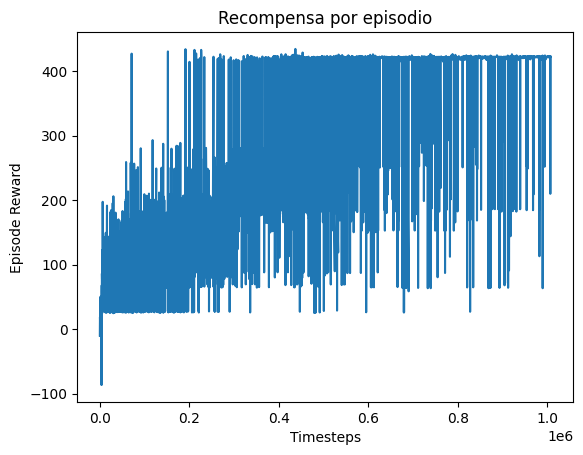

In [9]:

# Inicializamos el modelo con PPO y una política MLP
model = PPO(
    "CnnPolicy",
    env,
    verbose=1,
    tensorboard_log="./mario_logs/",
    learning_rate=learning_rateDecay(5e-4),
    n_steps=512,
    policy_kwargs={"normalize_images": False}  
)

print("Modelo PPO inicializado correctamente.")

# Inicializamos el callback para guardar el modelo y registrar la información durante el entrenamiento
cb = TrainAndLogCallback(check_freq=10000, save_path="./mario_models/", start_steps=0, verbose=1)
# eval_callback = EvalCallback(env, eval_freq=10000, deterministic=True, render=False)

# Número de pasos para el entrenamiento
total_timesteps = 1e6

# Entrenamos el modelo
model.learn(total_timesteps=total_timesteps, callback=cb)

data = load_results("./mario_monitor_dir/")
x, y = ts2xy(data, 'timesteps')

plt.plot(x, y)
plt.xlabel("Timesteps")
plt.ylabel("Episode Reward")
plt.title("Recompensa por episodio")
plt.show()

# Guardamos el modelo final
model.save("mario_final_model")

# Cerramos el entorno
env.close()

---
---
## 4. 📈 Evaluación de la política

Una vez finalizado el entrenamiento, se procede a **evaluar el rendimiento** del modelo entrenado en un entorno independiente. El objetivo es medir su capacidad para generalizar, sin influencias del entorno de entrenamiento.

<blockquote style="border-left: 4px solid #2196f3; background: #f0f8ff; padding: 10px; color: #333;">
 <strong>📊 Métricas obtenidas:</strong>
<ul style="margin-top: 10px;">
  <li><strong>Recompensa media:</strong> indica el rendimiento promedio por episodio.</li>
  <li><strong>Recompensa máxima y mínima:</strong> muestran la estabilidad del comportamiento.</li>
  <li><strong>Número de episodios:</strong> define el tamaño de la muestra evaluada.</li>
</ul>
</blockquote>

La evaluación se realiza utilizando funciones proporcionadas por <code>Stable-Baselines3</code> como <code>evaluate_policy()</code>, y puede incluir visualización de episodios o almacenamiento de resultados para análisis posterior.


### 4.1 Visualización del comportamiento del agente

En la siguiente celda se realiza una **evaluación visual del modelo entrenado**. El agente se ejecuta durante un número definido de episodios, y su comportamiento se registra en tiempo real.

<blockquote style="border-left: 4px solid #00acc1; background: #e0f7fa; padding: 10px; color: #333;">
<strong>🎥 Objetivo:</strong> Evaluar y capturar el desempeño del agente mediante la creación de un <strong>GIF animado</strong> del entorno.
</blockquote>

El GIF generado ofrece una perspectiva clara del comportamiento aprendido: cómo se mueve el agente, si toma decisiones eficientes y si logra completar el nivel o mejorar su rendimiento:

In [23]:
import imageio
import time
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

env = create_mario_env(WORLD, STAGE, ACTION_TYPE, n_frames_stack=N_FRAMES_STACK, render_mode="rgb_array")
env = DummyVecEnv([lambda: env])

model = PPO.load("mario_final_model")

frames = []
N_EVAL_EPISODES = 1
MAX_STEPS = 600

for ep in range(N_EVAL_EPISODES):
    obs = env.reset()
    done = [False]
    steps = 0

    while not done[0] and steps < MAX_STEPS:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        frame = env.render(mode="rgb_array")
        frames.append(frame)
        time.sleep(0.02)
        steps += 1

env.close()
imageio.mimsave("mario_agent.gif", frames, fps=30, loop=0)
print("GIF guardado como 'mario_agent.gif'")


c:\Users\asahe\Desktop\UNIVERSIDAD\GIR24-25\MULTIROBOTS\PracticaRLMario\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
c:\Users\asahe\Desktop\UNIVERSIDAD\GIR24-25\MULTIROBOTS\PracticaRLMario\.venv\lib\site-packages\gym\utils\passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(


GIF guardado como 'mario_agent.gif'


### 4.2 Evaluación interactiva del agente (visualización en tiempo real)

En esta sección se evalúa el modelo entrenado ejecutándolo directamente sobre el entorno, mostrando el resultado **en pantalla en tiempo real**.

<blockquote style="border-left: 4px solid #03a9f4; background: #e8f7ff; padding: 10px; color: #333;">
<strong>📈 Objetivo:</strong> Observar el comportamiento actual del agente mientras interactúa con el entorno, identificando patrones aprendidos, errores y decisiones clave.
</blockquote>

Esta evaluación es útil para verificar si el agente ha aprendido una estrategia coherente, así como para detectar posibles fallos o comportamientos no deseados:


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
import time

######### EVALUACION CUANTITATIVA #########
# Creamos un nuevo entorno para evaluar el agente entrenado.
# Este entorno es el mismo que el utilizado para entrenar el agente, pero sin el vectorizado. Vigilad tambien el tipo de renderizado!
env = create_mario_env(WORLD, STAGE, ACTION_TYPE, n_frames_stack=N_FRAMES_STACK, render_mode="human")

# El entorno debe ser envuelto en un DummyVecEnv para la evaluación
env = DummyVecEnv([lambda: env])

# Cargamos el modelo entrenado
model = PPO.load("mario_final_model")

# Evaluamos el rendimiento del agente en el entorno especificado y mostramos la recompensa media y la desviación estándar.
N_EVAL_EPISODES = 10
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=N_EVAL_EPISODES, deterministic=True)

print(f"Mean reward: {mean_reward} +/- {std_reward}")

######### EVALUACION CUALITATIVA #########
# Importante! Los wrappers VecEnv devuelven solo done para el fin de estado, no trunk. 
# Del mismo modo, el reset() devuelve solo el estado y no la info.
# Tenlo en cuenta para el bucle de evaluación.

# Implementa un bucle de evaluación para analizar el rendimiento del agente entrenado de forma cualitativa.
# Consejo: añade time.sleep(0.02) tras renderizar el entorno para que la velocidad de juego sea más lenta y puedas ver mejor el rendimiento del agente.

# Reset the environment
obs = env.reset()
done = False
try:
    for e in range(N_EVAL_EPISODES):
        while not done:
            # Obtén la acción del modelo
            action, _ = model.predict(obs, deterministic=True)
            
            # Ejecuta la acción en el entorno y observa el nuevo estado, la recompensa, si ha terminado el episodio y la información adicional.
            obs, reward, done, info = env.step(action)
            
            # Renderiza el entorno para visualizar el juego
            env.render()

            # Control de la velocidad de juego
            time.sleep(0.02)
            
            if done:
                print("Episode finished. Resetting environment.")
                obs = env.reset()
                done = False
        done = False
except KeyboardInterrupt:
    print("Exiting...")
    env.close()
    exit()

# Cierra el entorno después de la evaluación
env.close()


c:\Users\asahe\Desktop\UNIVERSIDAD\GIR24-25\MULTIROBOTS\PracticaRLMario\.venv\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(
c:\Users\asahe\Desktop\UNIVERSIDAD\GIR24-25\MULTIROBOTS\PracticaRLMario\.venv\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


KeyboardInterrupt: 

: 